In [9]:
from IPython.core import display
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

%matplotlib inline

In [10]:
def readCsv(name, nrows=5000000):
    df = pd.read_csv(
        "data/expedia/{}.csv".format(name), 
        nrows=nrows,
        parse_dates=["date_time", "srch_ci", "srch_co"])
    df = df[df.is_booking == True].sample(400000)
    df["year"] = pd.DatetimeIndex(df['date_time']).year
    df["month"] = pd.DatetimeIndex(df['date_time']).month
    df["hour"] = pd.DatetimeIndex(df['date_time']).hour
    df["dayofweek"] = pd.DatetimeIndex(df['date_time']).dayofweek
    df["hour"] = pd.DatetimeIndex(df['date_time']).hour

    df["srch_ci_month"] = pd.DatetimeIndex(df['srch_ci']).month
    df["srch_ci_dayofweek"] = pd.DatetimeIndex(df['srch_ci']).dayofweek
    
    df["srch_co_month"] = pd.DatetimeIndex(df['srch_co']).month
    df["srch_co_dayofweek"] = pd.DatetimeIndex(df['srch_co']).dayofweek
    
    srch_ci_utime = pd.DatetimeIndex(df['srch_ci']).astype(np.int64) // 10**9 
    srch_co_utime = pd.DatetimeIndex(df['srch_co']).astype(np.int64) // 10**9 
    
    df["srch_days"] = (srch_co_utime - srch_ci_utime) / (3600 * 24)
    
    return df

df = readCsv("train")
print("shape: ", df.shape)
df.sample(5)

('shape: ', (400000, 33))


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,hotel_cluster,year,month,hour,dayofweek,srch_ci_month,srch_ci_dayofweek,srch_co_month,srch_co_dayofweek,srch_days
2082176,2013-10-25 10:01:30,23,1,1,184,28154,650.1518,453660,0,1,...,82,2013,10,10,4,12,3,12,0,4
3574930,2013-05-16 23:44:50,2,3,66,174,9890,226.8911,889899,1,0,...,79,2013,5,23,3,5,2,5,3,1
1485204,2014-09-20 09:49:55,37,1,141,472,19240,NaN,1131494,0,0,...,16,2014,9,9,5,9,5,9,6,1
3492052,2013-04-09 11:40:34,2,3,66,254,51351,NaN,659071,0,1,...,66,2013,4,11,1,7,5,8,5,7
1660615,2013-08-01 19:03:24,23,1,1,217,40787,4958.3080,448290,0,0,...,29,2013,8,19,3,8,4,8,6,2



### File descriptions
```
train.csv - the training set
test.csv - the test set
destinations.csv - hotel search latent attributes
sample_submission.csv - a sample submission file in the correct format
```

### Data fields

train/test.csv
```
Column name	Description	Data type
date_time	Timestamp	string
site_name	ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)	int
posa_continent	ID of continent associated with site_name	int
user_location_country	The ID of the country the customer is located	int
user_location_region	The ID of the region the customer is located	int
user_location_city	The ID of the city the customer is located	int
orig_destination_distance	Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated	double
user_id	ID of user	int
is_mobile	1 when a user connected from a mobile device, 0 otherwise	tinyint
is_package	1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise	int
channel	ID of a marketing channel	int
srch_ci	Checkin date	string
srch_co	Checkout date	string
srch_adults_cnt	The number of adults specified in the hotel room	int
srch_children_cnt	The number of (extra occupancy) children specified in the hotel room	int
srch_rm_cnt	The number of hotel rooms specified in the search	int
srch_destination_id	ID of the destination where the hotel search was performed	int
srch_destination_type_id	Type of destination	int
hotel_continent	Hotel continent	int
hotel_country	Hotel country	int
hotel_market	Hotel market	int
is_booking	1 if a booking, 0 if a click	tinyint
cnt	Numer of similar events in the context of the same user session	bigint
hotel_cluster	ID of a hotel cluster	int
```

destinations.csv
```
Column name	Description	Data type
srch_destination_id	ID of the destination where the hotel search was performed	int
d1-d149	latent description of search regions	double
```

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1080412 to 4451672
Data columns (total 33 columns):
date_time                    50000 non-null datetime64[ns]
site_name                    50000 non-null int64
posa_continent               50000 non-null int64
user_location_country        50000 non-null int64
user_location_region         50000 non-null int64
user_location_city           50000 non-null int64
orig_destination_distance    33230 non-null float64
user_id                      50000 non-null int64
is_mobile                    50000 non-null int64
is_package                   50000 non-null int64
channel                      50000 non-null int64
srch_ci                      50000 non-null object
srch_co                      50000 non-null object
srch_adults_cnt              50000 non-null int64
srch_children_cnt            50000 non-null int64
srch_rm_cnt                  50000 non-null int64
srch_destination_id          50000 non-null int64
srch_destination_typ

In [5]:
df.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_cluster,year,month,hour,dayofweek,srch_ci_month,srch_ci_dayofweek,srch_co_month,srch_co_dayofweek,srch_days
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,33230.000000,5.000000e+04,50000.00000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,9.118720,2.706540,86.617660,312.873740,27767.322120,1701.243120,6.003417e+05,0.09686,0.136100,6.189620,...,47.701260,2013.661340,6.988100,13.308220,2.718920,7.106420,3.096900,7.041760,3.280400,2.433300
std,11.749028,0.727538,57.896608,202.169476,16787.682691,2162.726784,3.449511e+05,0.29577,0.342898,3.616823,...,29.095433,0.473259,3.281721,5.461276,1.961599,3.309174,1.939109,3.327726,2.068241,2.060543
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.005600,1.690000e+02,0.00000,0.000000,0.000000,...,0.000000,2013.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,2.000000,3.000000,66.000000,174.000000,13092.500000,416.966750,3.004300e+05,0.00000,0.000000,2.000000,...,22.000000,2013.000000,4.000000,9.000000,1.000000,5.000000,1.000000,4.000000,1.000000,1.000000
50%,2.000000,3.000000,66.000000,317.000000,27655.000000,2258.820300,6.013020e+05,0.00000,0.000000,9.000000,...,46.000000,2014.000000,7.000000,13.000000,3.000000,7.000000,3.000000,7.000000,3.000000,2.000000
75%,11.000000,3.000000,69.000000,395.000000,42328.000000,NaN,8.991078e+05,0.00000,0.000000,9.000000,...,72.000000,2014.000000,10.000000,18.000000,4.000000,10.000000,5.000000,10.000000,5.000000,3.000000
max,53.000000,4.000000,239.000000,1021.000000,56507.000000,11767.514600,1.198784e+06,1.00000,1.000000,10.000000,...,99.000000,2014.000000,12.000000,23.000000,6.000000,12.000000,6.000000,12.000000,6.000000,28.000000


### Removing outliers
@TODO: explain what I am doing here.

In [6]:
print "before removing outliers :", df.shape
df = df[(df["srch_days"] < 18) & (df["srch_days"] > -1)]
print "after removing outliers :", df.shape

before removing outliers : (50000, 33)
after removing outliers : (49934, 33)


### Treating Missing values

In [7]:
def removeMisingvalues(df):
    """
    remove data rows associated with any missing value
    """
    return df[
        df.orig_destination_distance.notnull() &
        df.srch_ci.notnull()
    ]

print "before removing missing values :", df.shape
df = removeMisingvalues(df)
print "after removing missing values :", df.shape

before removing missing values : (49934, 33)
after removing missing values : (33196, 33)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33196 entries, 1080412 to 4451672
Data columns (total 33 columns):
date_time                    33196 non-null datetime64[ns]
site_name                    33196 non-null int64
posa_continent               33196 non-null int64
user_location_country        33196 non-null int64
user_location_region         33196 non-null int64
user_location_city           33196 non-null int64
orig_destination_distance    33196 non-null float64
user_id                      33196 non-null int64
is_mobile                    33196 non-null int64
is_package                   33196 non-null int64
channel                      33196 non-null int64
srch_ci                      33196 non-null object
srch_co                      33196 non-null object
srch_adults_cnt              33196 non-null int64
srch_children_cnt            33196 non-null int64
srch_rm_cnt                  33196 non-null int64
srch_destination_id          33196 non-null int64
srch_destination_typ

### Data exploration

In [9]:
def exploreUnivariate(column):
    print "\n-------------------------\nColumn: {}\n".format(column.name)
    print column.describe()
    try:
        sns.distplot(column)
    except:
        print "cannot be plotted"
    plt.show()
#exploreUnivariate(df["srch_days"])
# exploreUnivariate(np.log(df["srch_days"]))  # less skewness


-------------------------
Column: site_name

count    33196.000000
mean         5.894234
std          8.763877
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         53.000000
Name: site_name, dtype: float64


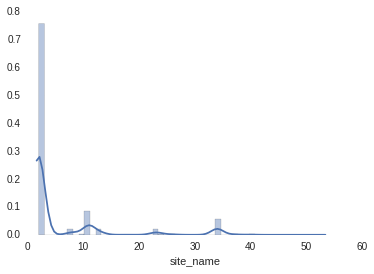


-------------------------
Column: posa_continent

count    33196.000000
mean         2.908603
std          0.506702
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: posa_continent, dtype: float64


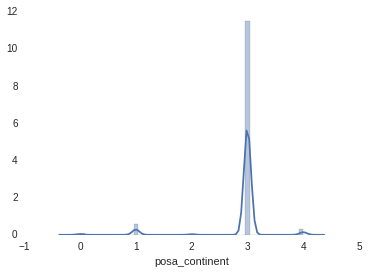


-------------------------
Column: user_location_country

count    33196.000000
mean        86.916737
std         53.256680
min          0.000000
25%         66.000000
50%         66.000000
75%         66.000000
max        215.000000
Name: user_location_country, dtype: float64


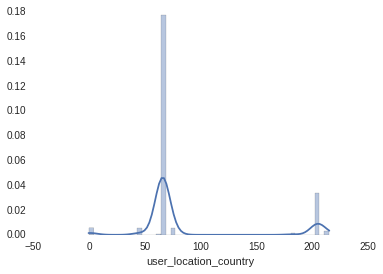


-------------------------
Column: user_location_region

count    33196.000000
mean       309.720358
std        137.855025
min        135.000000
25%        174.000000
50%        321.000000
75%        363.000000
max       1021.000000
Name: user_location_region, dtype: float64


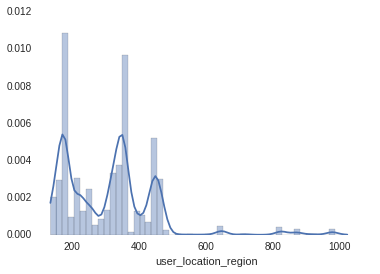


-------------------------
Column: user_location_city

count    33196.000000
mean     27865.260423
std      16631.588070
min          0.000000
25%      13951.000000
50%      27259.500000
75%      42881.000000
max      56498.000000
Name: user_location_city, dtype: float64


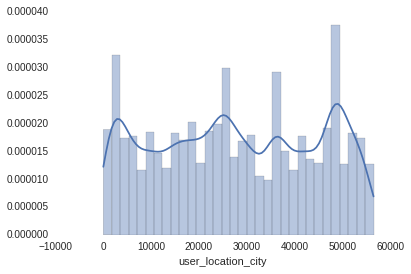


-------------------------
Column: orig_destination_distance

count    33196.000000
mean      1699.244638
std       2161.073177
min          0.005600
25%        220.695150
50%        823.364350
75%       2237.083175
max      11767.514600
Name: orig_destination_distance, dtype: float64


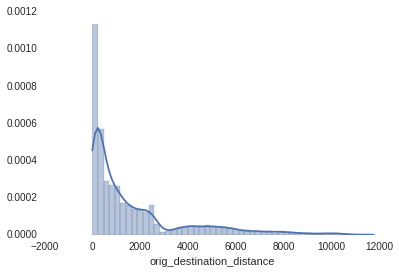


-------------------------
Column: user_id

count    3.319600e+04
mean     5.919059e+05
std      3.407085e+05
min      1.690000e+02
25%      3.003402e+05
50%      5.914530e+05
75%      8.863980e+05
max      1.198784e+06
Name: user_id, dtype: float64


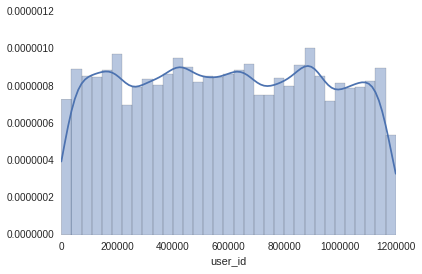


-------------------------
Column: is_mobile

count    33196.000000
mean         0.097632
std          0.296821
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_mobile, dtype: float64


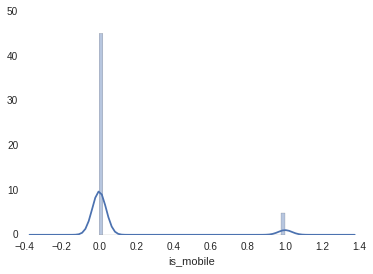


-------------------------
Column: is_package

count    33196.000000
mean         0.125648
std          0.331457
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_package, dtype: float64


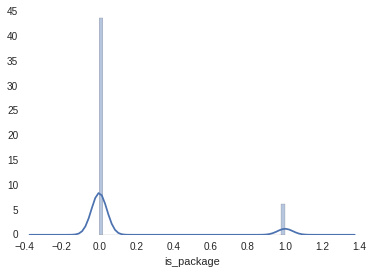


-------------------------
Column: channel

count    33196.000000
mean         6.304344
std          3.641439
min          0.000000
25%          2.000000
50%          9.000000
75%          9.000000
max         10.000000
Name: channel, dtype: float64


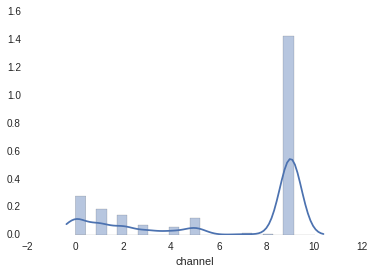


-------------------------
Column: srch_ci

count          33196
unique           989
top       2014-12-27
freq             152
Name: srch_ci, dtype: object
cannot be plotted


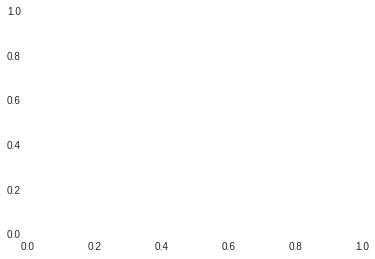


-------------------------
Column: srch_co

count          33196
unique           987
top       2014-12-28
freq             158
Name: srch_co, dtype: object
cannot be plotted


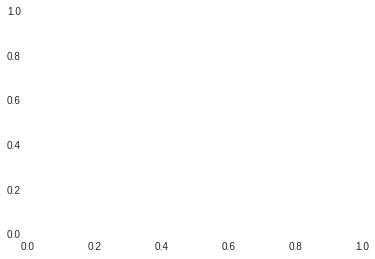


-------------------------
Column: srch_adults_cnt

count    33196.000000
mean         1.895168
std          0.923284
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          9.000000
Name: srch_adults_cnt, dtype: float64


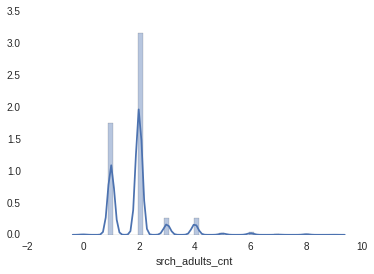


-------------------------
Column: srch_children_cnt

count    33196.000000
mean         0.275907
std          0.657948
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: srch_children_cnt, dtype: float64


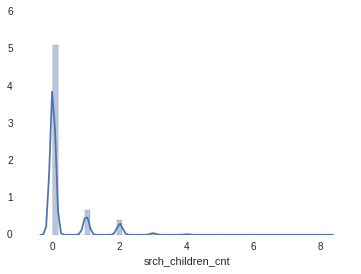


-------------------------
Column: srch_rm_cnt

count    33196.000000
mean         1.130407
std          0.485936
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: srch_rm_cnt, dtype: float64


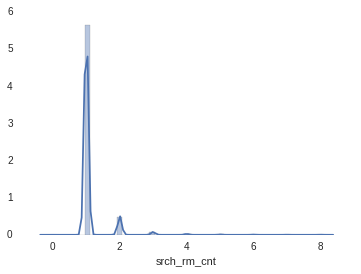


-------------------------
Column: srch_destination_id

count    33196.000000
mean     15295.044343
std      11379.523551
min          4.000000
25%       8266.000000
50%      11976.000000
75%      22171.250000
max      65031.000000
Name: srch_destination_id, dtype: float64


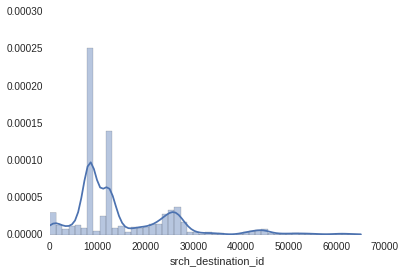


-------------------------
Column: srch_destination_type_id

count    33196.000000
mean         2.915893
std          2.212204
min          1.000000
25%          1.000000
50%          1.000000
75%          6.000000
max          8.000000
Name: srch_destination_type_id, dtype: float64


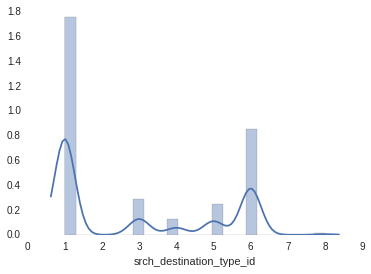


-------------------------
Column: is_booking

count    33196.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: is_booking, dtype: float64
cannot be plotted


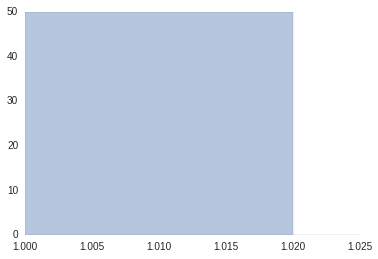


-------------------------
Column: cnt

count    33196.000000
mean         1.013375
std          0.132191
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: cnt, dtype: float64


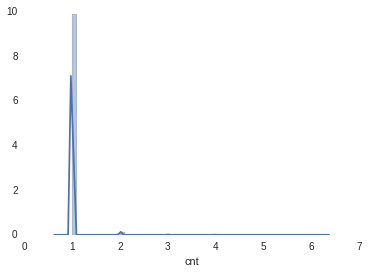


-------------------------
Column: hotel_continent

count    33196.000000
mean         2.683878
std          1.419132
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: hotel_continent, dtype: float64


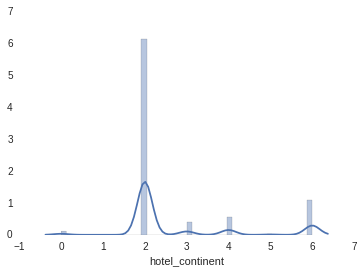


-------------------------
Column: hotel_country

count    33196.000000
mean        73.517321
std         51.793244
min          0.000000
25%         50.000000
50%         50.000000
75%         70.000000
max        212.000000
Name: hotel_country, dtype: float64


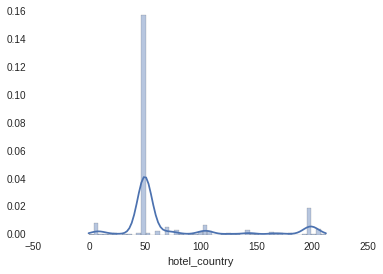


-------------------------
Column: hotel_market

count    33196.000000
mean       638.027292
std        440.433892
min          1.000000
25%        366.000000
50%        628.000000
75%        701.000000
max       2117.000000
Name: hotel_market, dtype: float64


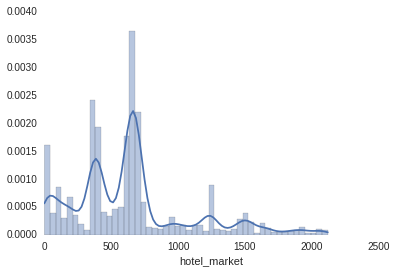


-------------------------
Column: hotel_cluster

count    33196.000000
mean        47.408513
std         29.264120
min          0.000000
25%         21.000000
50%         46.000000
75%         72.000000
max         99.000000
Name: hotel_cluster, dtype: float64


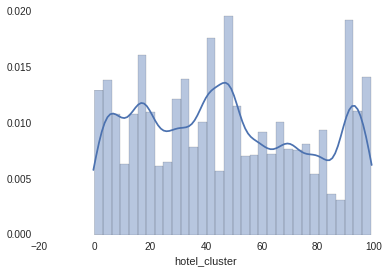


-------------------------
Column: year

count    33196.000000
mean      2013.663423
std          0.472546
min       2013.000000
25%       2013.000000
50%       2014.000000
75%       2014.000000
max       2014.000000
Name: year, dtype: float64


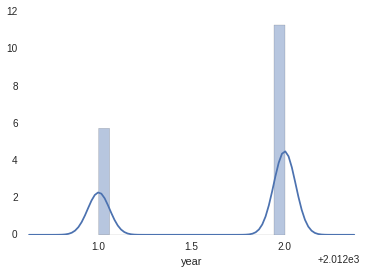


-------------------------
Column: month

count    33196.000000
mean         6.979003
std          3.281337
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64


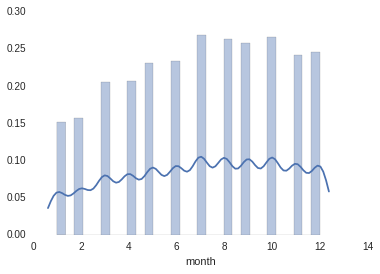


-------------------------
Column: hour

count    33196.000000
mean        13.393903
std          5.186863
min          0.000000
25%         10.000000
50%         13.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64


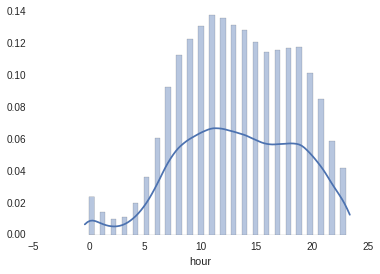


-------------------------
Column: dayofweek

count    33196.000000
mean         2.702796
std          1.952885
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: dayofweek, dtype: float64


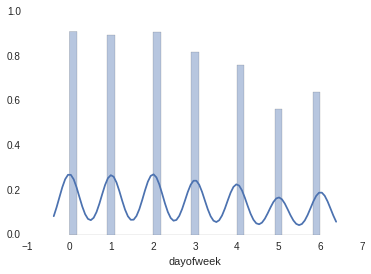


-------------------------
Column: srch_ci_month

count    33196.000000
mean         7.099229
std          3.302727
min          1.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: srch_ci_month, dtype: float64


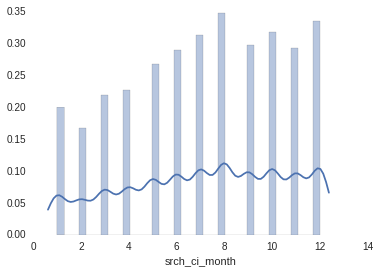


-------------------------
Column: srch_ci_dayofweek

count    33196.000000
mean         3.111489
std          1.932997
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: srch_ci_dayofweek, dtype: float64


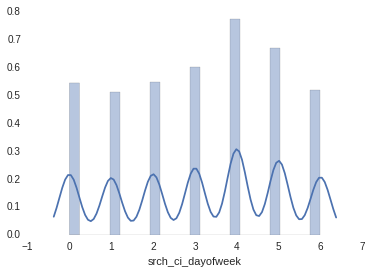


-------------------------
Column: srch_co_month

count    33196.000000
mean         7.048199
std          3.319012
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: srch_co_month, dtype: float64


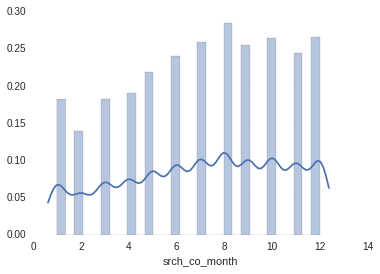


-------------------------
Column: srch_co_dayofweek

count    33196.000000
mean         3.317839
std          2.077570
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          6.000000
Name: srch_co_dayofweek, dtype: float64


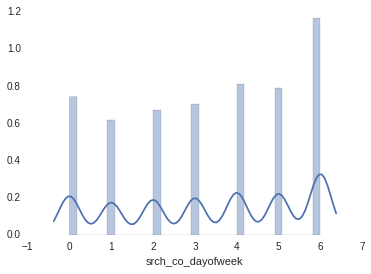


-------------------------
Column: srch_days

count    33196.000000
mean         2.306181
std          1.815665
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         17.000000
Name: srch_days, dtype: float64


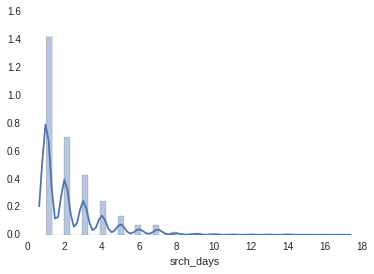

In [10]:
for i in df.drop(labels=["date_time"], axis=1).columns:
    exploreUnivariate(df[i])

In [11]:
# @TODO: plot bivariate charts

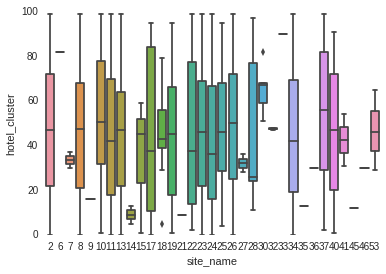

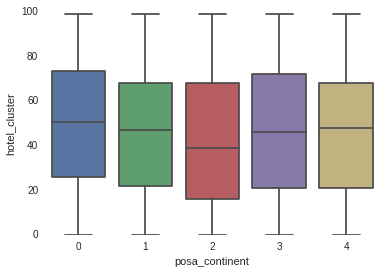

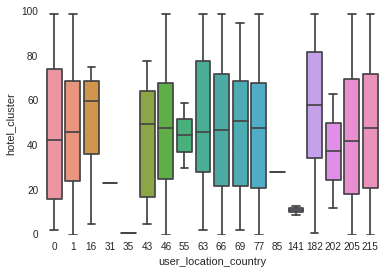

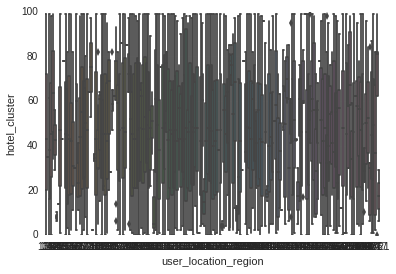

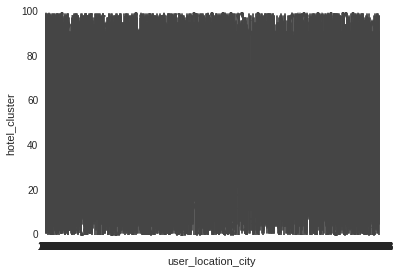

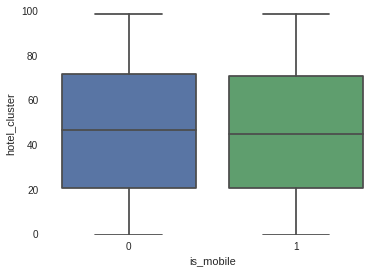

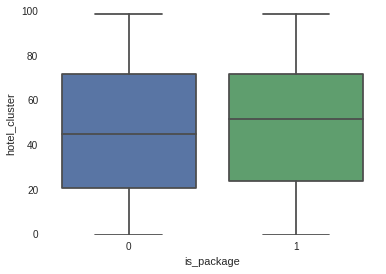

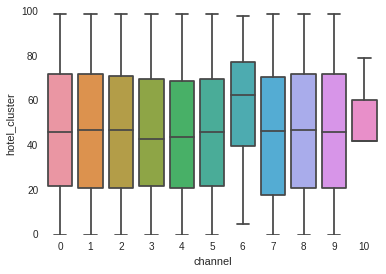

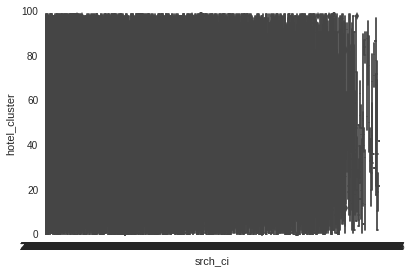

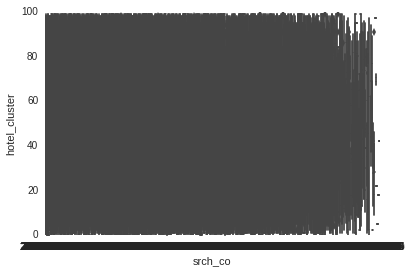

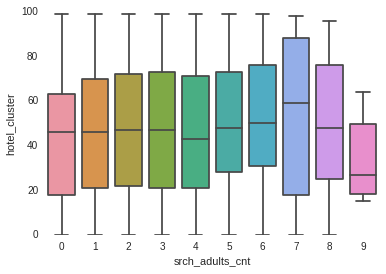

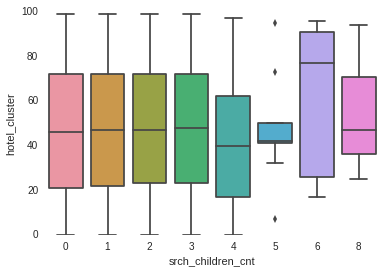

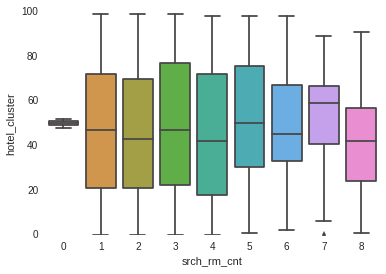

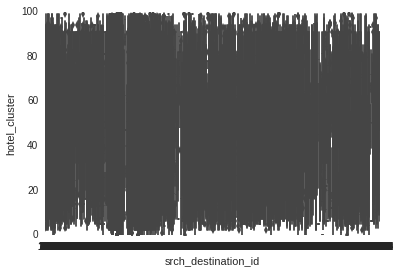

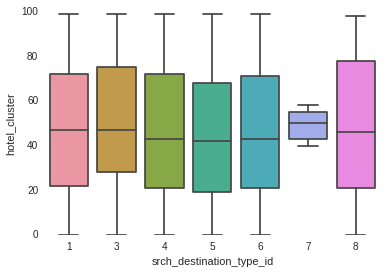

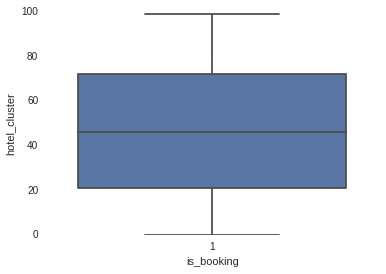

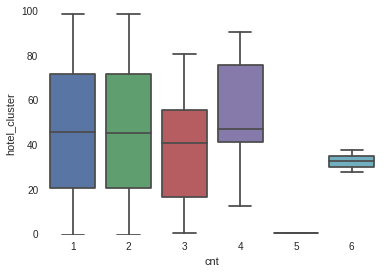

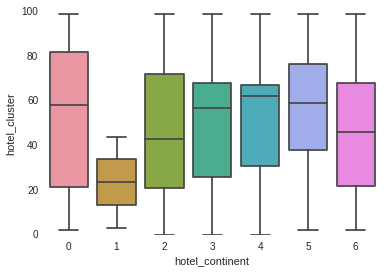

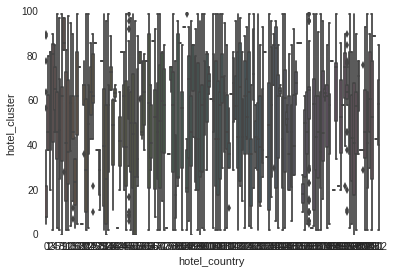

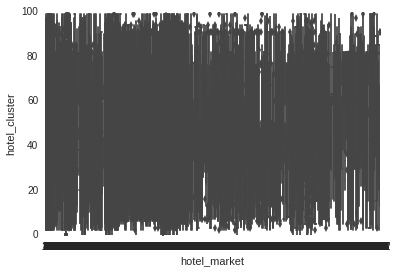

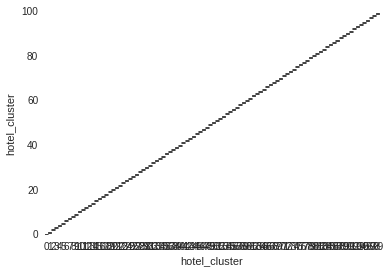

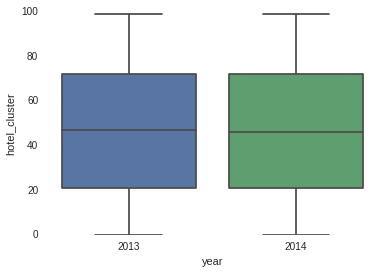

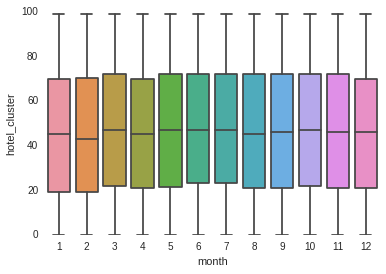

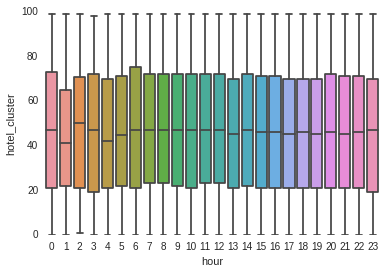

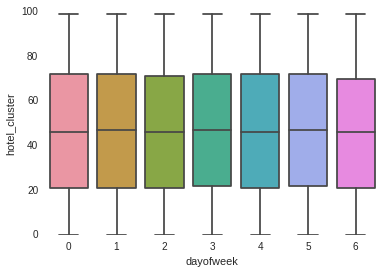

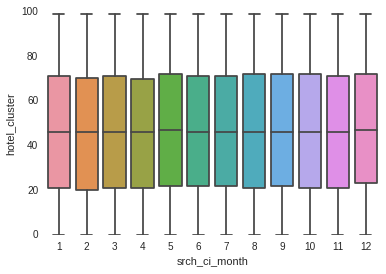

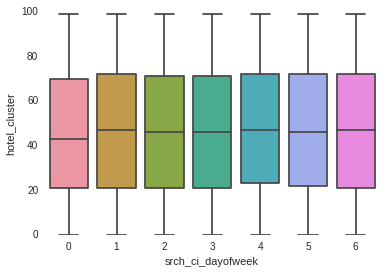

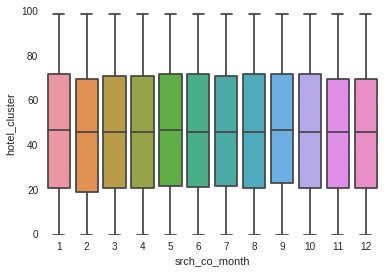

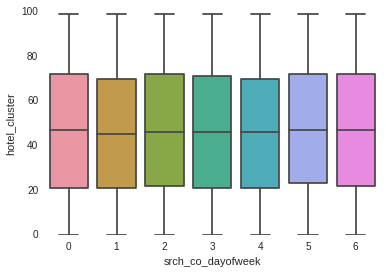

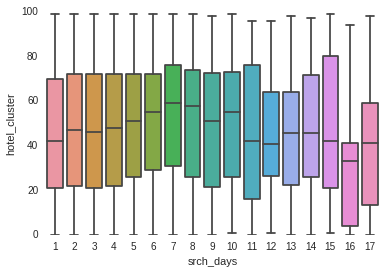

In [12]:
cols = [u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster', u'year', u'month',
       u'hour', u'dayofweek', u'srch_ci_month', u'srch_ci_dayofweek',
       u'srch_co_month', u'srch_co_dayofweek', u'srch_days']

for i in cols:
    sns.boxplot(x=i, y="hotel_cluster", data=df)
    plt.show()


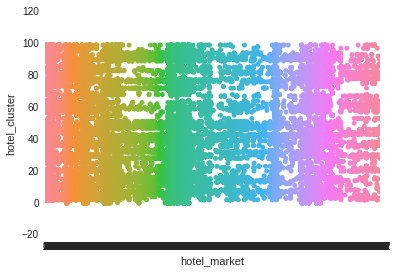

In [20]:
sns.stripplot(x="hotel_market", y="hotel_cluster", data=df, jitter=True)

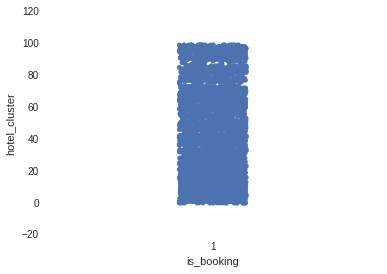

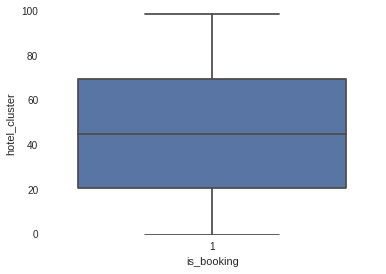

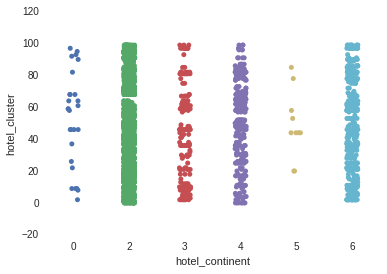

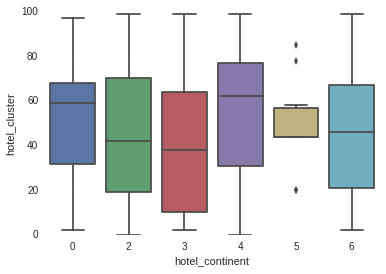

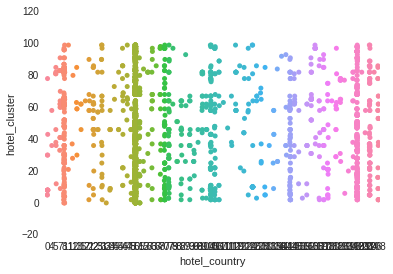

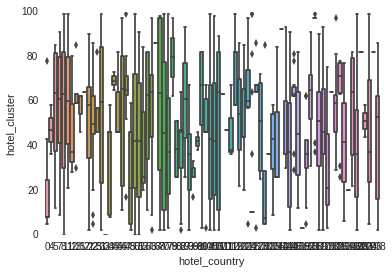

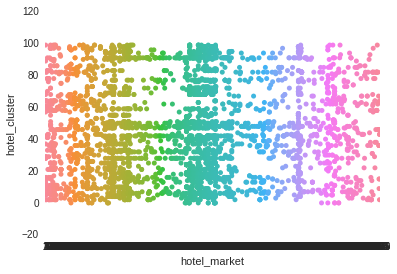

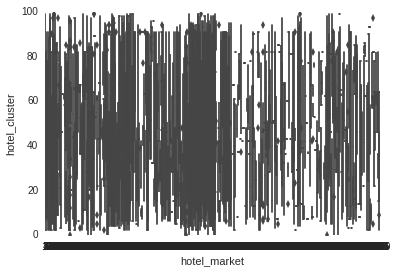

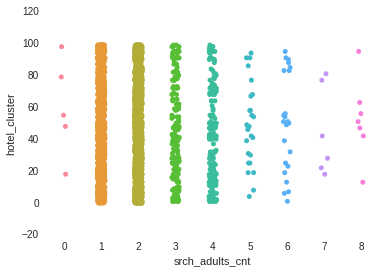

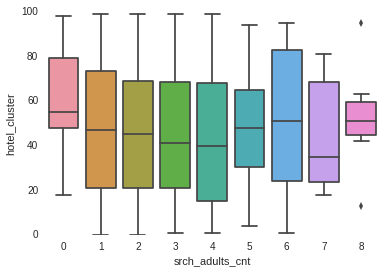

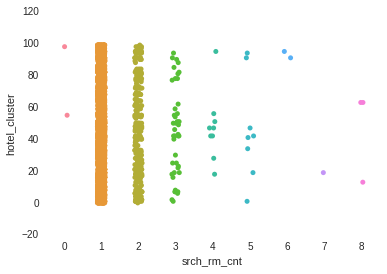

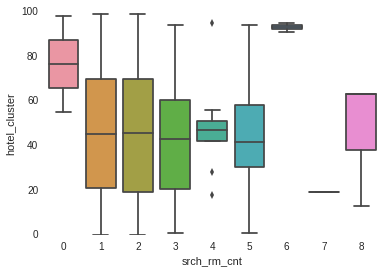

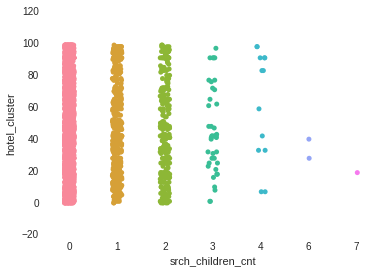

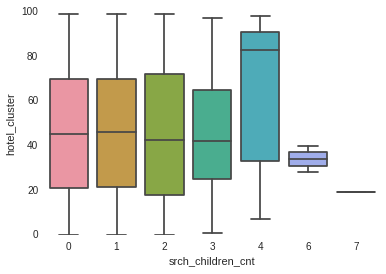

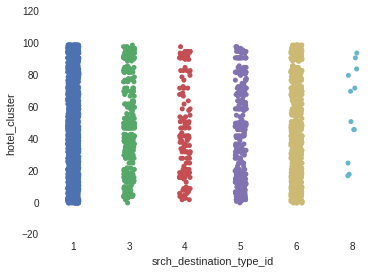

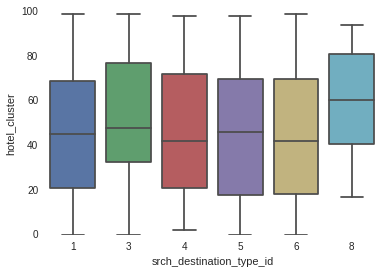

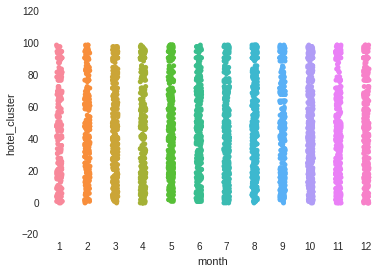

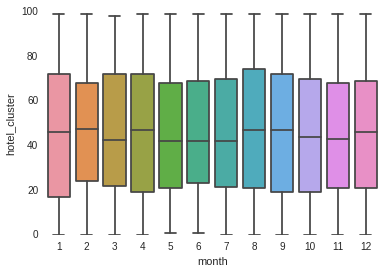

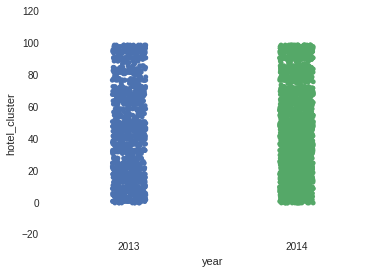

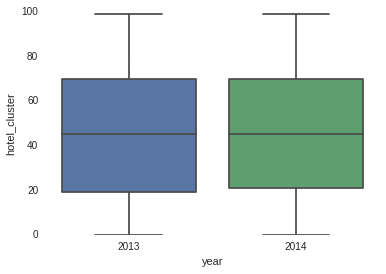

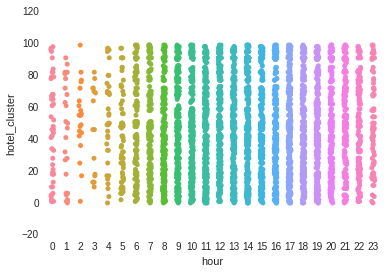

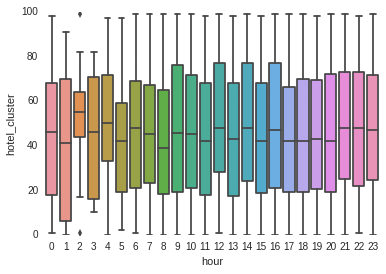

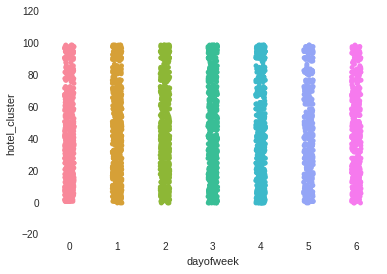

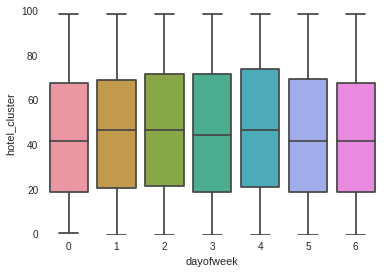

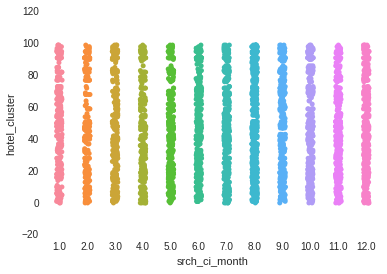

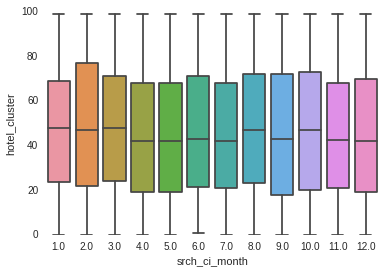

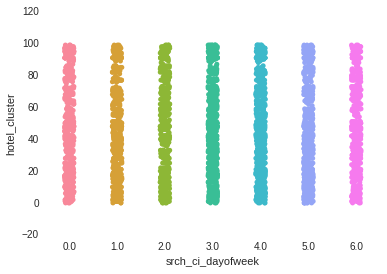

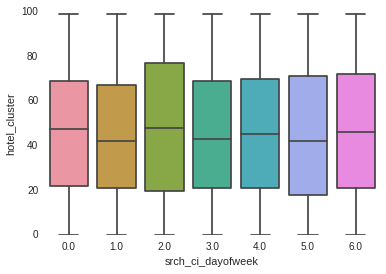

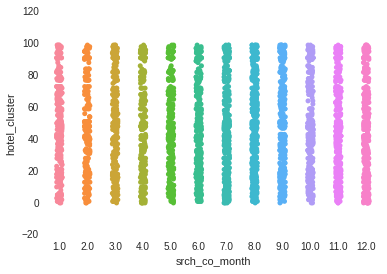

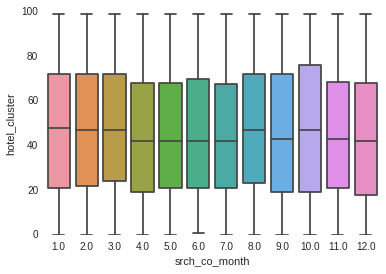

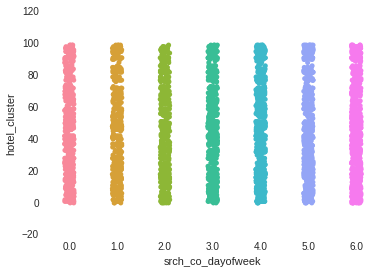

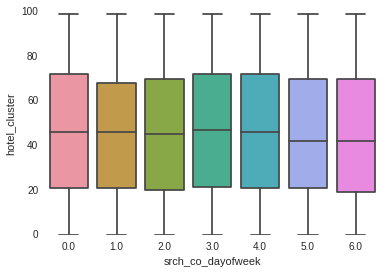

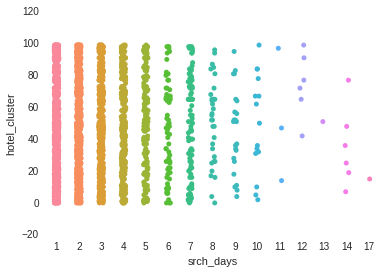

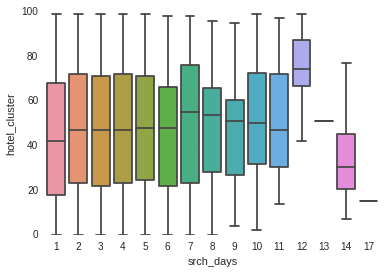

In [21]:
def biVariate(df):
    cols = [
        "hotel_continent", "hotel_country", "hotel_market",
        "srch_adults_cnt", "srch_rm_cnt", "srch_children_cnt", 
        "srch_destination_type_id", 
        "month", "year", "hour", "dayofweek", "srch_ci_month", 
        "srch_ci_dayofweek", "srch_co_month", "srch_co_dayofweek", "srch_days"]
    for i in cols:
        sns.stripplot(x=i, y="hotel_cluster", data=df, jitter=True)
        plt.show()
        sns.boxplot(x=i, y="hotel_cluster", data=df)
        plt.show()
biVariate(df[df.is_booking == 1])

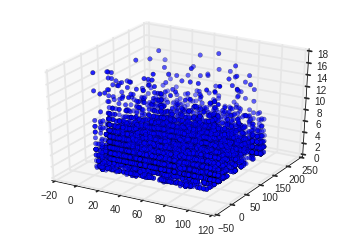

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(df["hotel_cluster"], df["hotel_country"], df["srch_days"], c="b")

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 3833548 to 2732975
Data columns (total 33 columns):
date_time                    50000 non-null datetime64[ns]
site_name                    50000 non-null int64
posa_continent               50000 non-null int64
user_location_country        50000 non-null int64
user_location_region         50000 non-null int64
user_location_city           50000 non-null int64
orig_destination_distance    33080 non-null float64
user_id                      50000 non-null int64
is_mobile                    50000 non-null int64
is_package                   50000 non-null int64
channel                      50000 non-null int64
srch_ci                      50000 non-null object
srch_co                      50000 non-null object
srch_adults_cnt              50000 non-null int64
srch_children_cnt            50000 non-null int64
srch_rm_cnt                  50000 non-null int64
srch_destination_id          50000 non-null int64
srch_destination_typ

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

In [11]:
clf = RandomForestClassifier(n_estimators=10)

a = df[[
        "hotel_continent",
        "hotel_market",
        "user_location_country",
        "srch_destination_type_id", 
        "hotel_country", 
        "is_package",
        "srch_ci_month", 
        "srch_days",
        "hotel_cluster"
    ]]

X = a.drop(labels=["hotel_cluster"], axis=1)
y = a["hotel_cluster"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=0)


clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.13171250000000001

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel="rbf", gamma=0.002)

a = df[[
        "hotel_continent",
        "hotel_market",
        "user_location_country",
        "srch_destination_type_id", 
        "hotel_country", 
        "is_package",
        "srch_ci_month", 
        "srch_days",
        "hotel_cluster"
    ]]

X = a.drop(labels=["hotel_cluster"], axis=1)
y = a["hotel_cluster"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=0)


clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
clf.pr